<a href="https://colab.research.google.com/github/sromanov103/face_generation/blob/main/face_generation(VAE_StyleGAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Тема:** "Генерация реалистичных изображений с помощью вариационных автокодировщиков (VAE) с применением архитектуры StyleGAN.
**Актуальность:** Вариационные автокодировщики VAE и StyleGAN представляют собой методы генерации изображений, которые находят широкое применение в различных областях, включая искусственный интеллект, компьютерное зрение и графику. Эти технологии позволяют создавать высококачественные и реалистичные изображения, что делает их особенно актуальными в индустрии развлечений, маркетинге и научных исследованиях.

**Задача:** Сравнить качество генерации VAE и StyleGAN.
Применение VAE для генерации изображений в конкретной предметной области лиц.

**Автор:** *Романов Сергей Евгеньевич*

#Обучение VAE

**Загрузка необходимых библиотек:** Библиотеки torch и torchvision используются для разработки и обучения моделей глубокого обучения,torch предоставляет основные функции для работы с тензорами и нейронными сетями, а torchvision предлагает инструменты для обработки изображений и предобученные модели.

In [ ]:
!pip install torch torchvision

**Ипорт модулей:**



1.   kagglehub: Позволяет загружать и управлять данными из Kaggle, упрощая доступ к наборам данных для анализа и обучения моделей.
2.   os: Предоставляет функции для взаимодействия с операционной системой, такие как работа с файловой системой.
3.   zipfile: Используется для работы с ZIP-архивами, позволяя распаковывать и создавать архивы.
4.   pandas: Библиотека для анализа и манипуляции данными, предоставляющая удобные структуры данных, такие как DataFrame.
5.   torch: Основная библиотека для работы с тензорами и нейронными сетями в PyTorch.
6.   torch.nn: Модуль, содержащий классы для создания нейронных сетей, включая слои и функции активации.
7.  torch.nn.functional: Предоставляет функции активации и другие операции, которые могут быть использованы в нейронных сетях.
8.   torch.optim: Содержит алгоритмы оптимизации для обучения моделей, такие как SGD и Adam.
9.   torchvision.transforms: Предоставляет инструменты для предварительной обработки изображений, такие как изменение размера и нормализация.
10.   tensorflow: Библиотека для машинного обучения и глубокого обучения, предоставляющая инструменты для создания и обучения моделей.
11.   tensorflow.keras: Высокоуровневый API для создания и обучения нейронных сетей в TensorFlow.
12.   matplotlib.pyplot: Библиотека для визуализации данных, позволяющая создавать графики и диаграммы.
13.   matplotlib.image: Модуль для работы с изображениями в Matplotlib.
14.   torch.utils.data: Содержит классы для работы с наборами данных и загрузчиками данных в PyTorch.
15.   PIL (Python Imaging Library): Библиотека для обработки изображений, позволяющая открывать, изменять и сохранять изображения.
16.   torch.nn.utils.spectral_norm: Функция для применения спектральной нормализации к слоям нейронной сети, что помогает стабилизировать обучение.
17.   cv2 (OpenCV): Библиотека для компьютерного зрения, предоставляющая функции для обработки изображений и видео.
18.   numpy: Библиотека для работы с многомерными массивами и матрицами, а также для выполнения математических операций над ними.

In [ ]:
import kagglehub
import os
import zipfile
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.nn.utils import spectral_norm

import tensorflow as tf
import cv2
import numpy as np

Подготовка данных и скачивание датасета

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 99% 1.32G/1.33G [00:17<00:00, 82.4MB/s]
100% 1.33G/1.33G [00:17<00:00, 82.7MB/s]


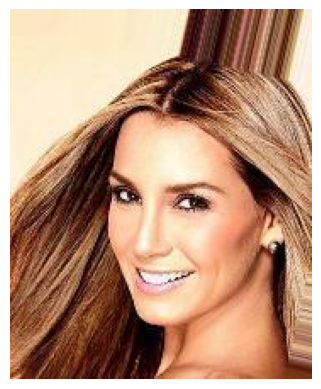

In [ ]:
# Создаем папку ds
os.makedirs('/content/ds', exist_ok=True)

# Скачиваем датасет CelebA в папку ds
!kaggle datasets download -d jessicali9530/celeba-dataset -p /content/ds

# Распаковываем загруженный zip-файл
with zipfile.ZipFile('/content/ds/celeba-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/ds')

# Путь к папке с изображениями
image_folder = '/content/ds/img_align_celeba/img_align_celeba/'

# Выводим одно изображение
image_path = os.path.join(image_folder, '000001.jpg')  # Замените на имя нужного изображения
img = mpimg.imread(image_path)

plt.imshow(img)
plt.axis('off')  # Отключаем оси
plt.show()

Информация о датасете для анализа

In [ ]:
# Путь к CSV-файлу с метаданными
metadata_path = '/content/ds/list_attr_celeba.csv'

# Загружаем метаданные
metadata = pd.read_csv(metadata_path)

# Выводим информацию о датасете
print("Формат датасета:")
print(metadata.head())  # Показываем первые 5 строк

# Выводим количество изображений
print("\nКоличество изображений в датасете:", len(metadata))

# Выводим информацию о столбцах
print("\nСтолбцы в датасете:")
print(metadata.columns)

# Выводим информацию о типах данных
print("\nТипы данных в датасете:")
print(metadata.dtypes)

Формат датасета:
     image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings

Нормализация датасета крайне важна в генерации изображений, обеспечивая стабильность, качество и эффективность обучения. Она способствует созданию более реалистичных и разнообразных изображений, что делает её важным этапом в процессе подготовки данных для генеративных моделей. С ее помощью можно устранить дисбалансы, смягчить влияние выбросов, а так же поможет улучшить результаты моделей машинного обучения

In [ ]:
# Создаем папку normalized_dataset'
new_dataset_folder = '/content/ds/normalized_dataset'
os.makedirs(new_dataset_folder, exist_ok=True)  # Создаем папку, если она не существует

def load_and_preprocess_image(filename):
    try:
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [128, 128])  # Измените размер по необходимости
        img = img / 255.0  # Нормализация
        return img
    except Exception as e:
        print(f"Ошибка при загрузке изображения {filename}: {e}")
        return None

def create_dataset(image_folder, batch_size=32):
    # Получаем список всех изображений
    image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]

    def generator():
        for path in image_paths:
            img = load_and_preprocess_image(path)
            if img is not None:
                yield img

    # Создаем tf.data.Dataset из генератора
    dataset = tf.data.Dataset.from_generator(generator, output_signature=tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32))
    dataset = dataset.batch(batch_size, drop_remainder=True)  # Отбрасываем последний батч, если он меньше batch_size
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Предварительная загрузка данных
    return dataset

def save_normalized_images(dataset, folder):
    for i, batch_images in enumerate(dataset):
        for j, img in enumerate(batch_images):
            img_np = (img.numpy() * 255).astype(np.uint8)  # Обратная нормализация
            img_path = os.path.join(folder, f'image_{i * 32 + j:04d}.jpg')  # Форматирование имени файла
            cv2.imwrite(img_path, img_np)  # Сохранение изображения

# Создаем датасет
batch_size = 32
dataset = create_dataset(image_folder, batch_size)

# Проверка на наличие None значений в датасете
for batch_images in dataset.take(1):
    if batch_images is None:
        print("Найдены None значения в датасете!")
    else:
        print("Размер батча:", batch_images.shape)

# Сохраняем нормализованные изображения в новую папку
save_normalized_images(dataset, new_dataset_folder)

# Пример использования
for batch_images in dataset.take(1):  # Получаем один батч
    print(batch_images.shape)  # Размер батча

Размер батча: (32, 128, 128, 3)
(32, 128, 128, 3)


Пример нормализованных изображений

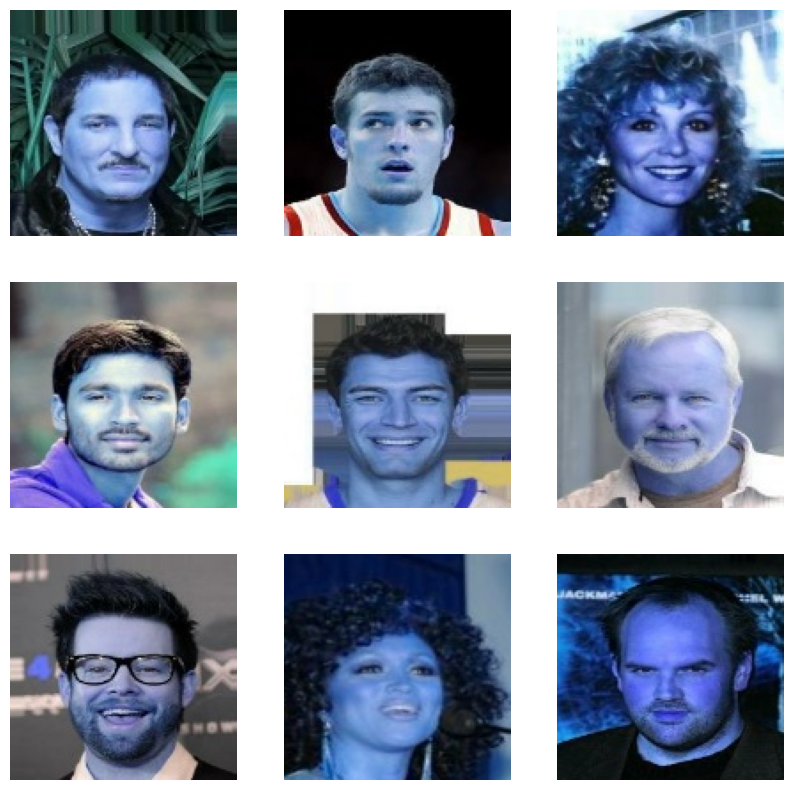

In [ ]:
# Путь к папке с нормализованными изображениями
normalized_image_folder = new_dataset_folder

# Получаем список всех изображений в папке
normalized_image_paths = [os.path.join(normalized_image_folder, filename) for filename in os.listdir(normalized_image_folder)]

# Отображаем несколько изображений
plt.figure(figsize=(10, 10))
for i in range(9):  # Отображаем 9 изображений
    img = mpimg.imread(normalized_image_paths[i])
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

Проверка структуры датасета


In [ ]:
for batch_images in dataset.take(1):  # Получаем один батч
    print("Размер батча:", batch_images.shape)  # Размер батча
    print("Пример изображения:", batch_images[0])  # Выводим первое изображение

Размер батча: (32, 128, 128, 3)
Пример изображения: tf.Tensor(
[[[0.89411765 0.8745098  0.85882354]
  [0.89411765 0.8745098  0.85882354]
  [0.89411765 0.8745098  0.85882354]
  ...
  [0.87058824 0.85882354 0.8392157 ]
  [0.86896443 0.8571997  0.8343444 ]
  [0.8666667  0.85490197 0.827451  ]]

 [[0.89411765 0.8745098  0.85882354]
  [0.89411765 0.8745098  0.85882354]
  [0.89411765 0.8745098  0.85882354]
  ...
  [0.87058824 0.85882354 0.8392157 ]
  [0.86896443 0.8571997  0.8343444 ]
  [0.8666667  0.85490197 0.827451  ]]

 [[0.89411765 0.8745098  0.85882354]
  [0.89411765 0.8745098  0.85882354]
  [0.89411765 0.8745098  0.85882354]
  ...
  [0.87058824 0.85882354 0.8392157 ]
  [0.86896443 0.8571997  0.8343444 ]
  [0.8666667  0.85490197 0.827451  ]]

 ...

 [[0.91764706 0.90588236 0.87058824]
  [0.9130515  0.9081801  0.8751838 ]
  [0.9098039  0.9098039  0.8784314 ]
  ...
  [0.5095198  0.44285315 0.38010806]
  [0.51130015 0.44463345 0.38188836]
  [0.5233456  0.45667893 0.39393383]]

 [[0.921354

In [ ]:
for batch_images in dataset:
    if batch_images is None:
        print("Найдены None значения в датасете!")
    else:
        print("Размер батча:", batch_images.shape)

Выходные данные были обрезаны до нескольких последних строк (5000).
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Размер батча: (32, 128, 128, 3)
Разм

Класс VAE реализует вариационный автокодировщик, который состоит из кодировщика и декодировщика. VAE используется для генерации новых образцов данных, основываясь на обучении на существующих данных. Он включает в себя механизмы для кодирования входных данных в латентное пространство и декодирования из этого пространства обратно в исходное пространство.

In [ ]:
# Определяем класс VAE (вариационный автокодировщик)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, optimizer):
        super(VAE, self).__init__()
        self.optimizer = optimizer  # Сохраняем оптимизатор как атрибут класса

        # Определяем кодировщик
        self.encoder = models.Sequential([
            layers.Input(shape=(128, 128, 3)),  # Входной слой, принимающий изображения размером 128x128 с 3 каналами (RGB)
            layers.Conv2D(32, 3, activation='relu', padding='same'),  # Слой свертки с 32 фильтрами
            layers.MaxPooling2D(),  # Слой подвыборки для уменьшения размерности
            layers.Conv2D(64, 3, activation='relu', padding='same'),  # Второй слой свертки с 64 фильтрами
            layers.MaxPooling2D(),  # Второй слой подвыборки
            layers.Flatten(),  # Преобразуем многомерный массив в одномерный
            layers.Dense(latent_dim + latent_dim),  # Полносвязный слой, который выводит mean и log_var
        ])

        # Определяем декодировщик
        self.decoder = models.Sequential([
            layers.Input(shape=(latent_dim,)),  # Входной слой для латентного вектора
            layers.Dense(32 * 32 * 64, activation='relu'),  # Полносвязный слой для увеличения размерности
            layers.Reshape((32, 32, 64)),  # Преобразуем в 3D-формат для последующих слоев
            layers.Conv2DTranspose(64, 3, activation='relu', padding='same'),  # Транспонированный слой свертки
            layers.UpSampling2D(),  # Увеличиваем размерность изображения
            layers.Conv2DTranspose(32, 3, activation='relu', padding='same'),  # Второй транспонированный слой свертки
            layers.UpSampling2D(),  # Увеличиваем размерность изображения
            layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same'),  # Выходной слой, генерирующий RGB-изображение
        ])

    def encode(self, x):
        # Кодируем входные данные и получаем mean и log_var
        mean_log_var = self.encoder(x)
        mean, log_var = tf.split(mean_log_var, num_or_size_splits=2, axis=1)  # Разделяем на два вектора
        return mean, log_var  # Возвращаем mean и log_var

    def reparameterize(self, mean, log_var):
        # Реализуем метод репараметризации для сэмплирования из латентного пространства
        eps = tf.random.normal(shape=tf.shape(mean))  # Генерируем случайный шум
        return mean + tf.exp(0.5 * log_var) * eps  # Возвращаем сэмплированное значение

    def decode(self, z):
        # Декодируем латентный вектор обратно в изображение
        return self.decoder(z)

    def call(self, x):
        # Основной метод, который объединяет кодирование, репараметризацию и декодирование
        mean, log_var = self.encode(x)  # Кодируем входные данные
        z = self.reparameterize(mean, log_var)  # Сэмплируем из латентного пространства
        return self.decode(z), mean, log_var  # Возвращаем восстановленное изображение, mean и log_var

    @tf.function
    def train_step(self, x):
        # Выполняем один шаг обучения модели
        with tf.GradientTape() as tape:
            reconstructed, mean, log_var = self.call(x)  # Получаем восстановленное изображение и параметры латентного пространства
            # Вычисляем потерю
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(x, reconstructed)  # Потеря реконструкции
            )
            kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var))  # KL-дивергенция
            total_loss = reconstruction_loss + kl_loss  # Общая потеря

        # Обновляем веса модели
        gradients = tape .gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))  # Применяем градиенты
        return total_loss  # Возвращаем общую потерю

    def fit(self, dataset, epochs):
        # Обучаем модель на заданном наборе данных в течение указанного количества эпох
        for epoch in range(epochs):
            epoch_loss = 0  # Инициализируем переменную для хранения потерь за эпоху
            for step, x in enumerate(dataset):
                loss = self.train_step(x)  # Выполняем шаг обучения
                epoch_loss += loss  # Суммируем потери
            print(f'Epoch {epoch + 1}, Loss: {epoch_loss.numpy() / (step + 1)}')  # Выводим информацию о потере за эпоху

In [ ]:
# Параметры
latent_dim = 64
optimizer = tf.keras.optimizers.Adam()  # Создаем оптимизатор
vae = VAE(latent_dim, optimizer)  # Передаем оптимизатор в класс VAE

In [ ]:
# Обучение VAE
vae.fit(dataset, epochs=1)
# Визуализация графика потерь
plot_training_loss(vae.losses)

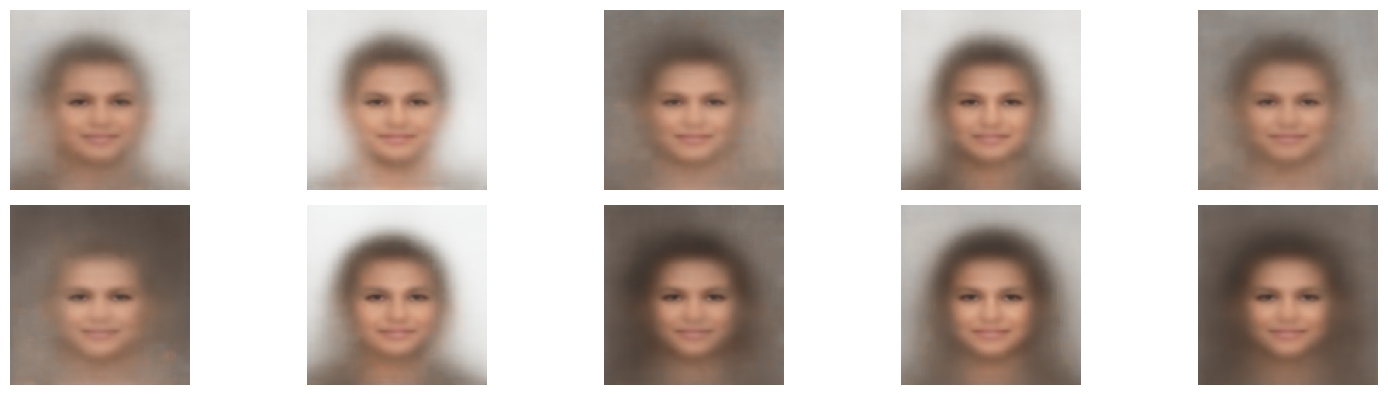

In [ ]:
def generate_images(vae, num_images):
    """
     Генерирует изображения с использованием вариационного автокодировщика (VAE).
    Параметры:
    vae: Объект VAE, используемый для декодирования латентных векторов.
    num_images: Количество изображений для генерации.
    Возвращает:
    generated_images: Сгенерированные изображения в формате uint8.
    """
    # Генерируем случайные латентные векторы
    random_latent_vectors = tf.random.normal(shape=(num_images, vae.encoder.layers[-1].units // 2))

    # Декодируем латентные векторы в изображения
    generated_images = vae.decode(random_latent_vectors)

    # Преобразуем изображения в формат, подходящий для отображения
    generated_images = (generated_images.numpy() * 255).astype(np.uint8)  # Преобразуем в формат uint8 для отображения

    return generated_images

# Пример использования функции
num_images_to_generate = 10
generated_images = generate_images(vae, num_images_to_generate)

# Визуализация сгенерированных изображений
plot_generated_images(generated_images)

#Обучение StyleGAN

**Генеративные состязательные сети (GAN)** — это класс моделей глубокого обучения, состоящих из двух нейронных сетей: генератора и дискриминатора. Генератор создает фейковые изображения, а дискриминатор пытается отличить реальные изображения от сгенерированных. Обе сети обучаются одновременно, что приводит к улучшению качества сгенерированных изображений.

**Основные концепции:**


1.   Набор данных: Используется набор данных CelebA, который содержит изображения лиц. Код загружает изображения из указанной папки и применяет предварительную обработку, такую как изменение размера и нормализация.

2.   Архитектура:
*Дискриминатор: Определяет, является ли изображение реальным или фейковым. Он использует несколько сверточных слоев для извлечения признаков из изображений.*

*Генератор (StyleGAN): Состоит из двух основных компонентов:*
*   Сеть отображения (Mapping Network): Преобразует латентные векторы в стили, которые затем используются для генерации изображений.
*   Сеть синтеза (Synthesis Network): Генерирует изображения на основе стилей, полученных от сети отображения.

**Обучение:**

Обучение происходит в цикле, где на каждой итерации:
Дискриминатор обучается на реальных и фейковых изображениях, получая метки для каждого типа.

Генератор обучается на основе выходов дискриминатора, чтобы улучшить качество сгенерированных изображений.

Используется бинарная кросс-энтропия в качестве функции потерь для оценки производительности обеих сетей.

**Добавление шума:** Для улучшения обучения к реальным изображениям добавляется шум, что помогает избежать переобучения и улучшает обобщающую способность модели.


**Архитектура:**

**Mapping Network:**


*   Состоит из нескольких полносвязных слоев с функцией активации Leaky ReLU.
*   Преобразует латентные векторы в стили, которые затем используются в сети синтеза.


**Synthesis Network:**


*   Начинается с транспонированного сверточного слоя, который увеличивает размер изображения.
*   Содержит несколько слоев, которые последовательно увеличивают размер изображения и уменьшают количество каналов, заканчиваясь на выходном слое с 3 каналами (RGB).



**Discriminator:**


*   Состоит из нескольких сверточных слоев, которые
 уменьшают размер изображения и увеличивают количество каналов.
*   Использует адаптивное усреднение для приведения выходного изображения к размеру 1x1, что позволяет получить вероятность того, что изображение является реальным.


In [ ]:
from torchvision import datasets, transforms

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os

# Класс для загрузки набора данных CelebA
class CelebADataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
def prepare_data(image_folder, batch_size):
    """
    Подготавливает данные для обучения, создавая загрузчик данных.

    Параметры:
    - image_folder: Папка с изображениями.
    - batch_size: Размер батча для загрузчика данных.

    Возвращает:
    - Загрузчик данных.
    """
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Измените размер на 128x128
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    dataset = CelebADataset(image_folder, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [ ]:
# Сеть для отображения латентного пространства
class MappingNetwork(nn.Module):
    def __init__(self, latent_dim, style_dim):
        """
        Инициализация сети отображения.
        Параметры:
        - latent_dim: Размер латентного пространства.
        - style_dim: Размер стиля.
        """
        super(MappingNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, style_dim)
        )
# Прямое распространение через сеть
    def forward(self, z):
        return self.model(z)

In [ ]:
class SynthesisNetwork(nn.Module):
    """
    Сеть для синтеза изображений на основе стиля.
    """
    def __init__(self, style_dim):
        """
        Инициализация сети синтеза.
        Параметры:
        - style_dim: Размер стиля.
        """
        super(SynthesisNetwork, self).__init__()
        self.initial_layer = nn.Sequential(
            nn.ConvTranspose2d(style_dim, 512, 4, 1, 0),
            nn.LeakyReLU(0.2)
        )
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(512, 256, 4, 2, 1),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(256, 128, 4, 2, 1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(128, 64, 4, 2, 1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2)
            ),
            nn.ConvTranspose2d(64, 3, 4, 2, 1)
        ])

    def forward(self, styles):
        x = self.initial_layer(styles.view(styles.size(0), -1, 1, 1))
        for layer in self.layers:
            x = layer(x)
        return torch.tanh(x)

In [ ]:
# Модель StyleGAN, состоящая из сети отображения и сети синтеза
class StyleGAN(nn.Module):
    def __init__(self, latent_dim, style_dim):
        """
        Инициализация модели StyleGAN.

        Параметры:
        - latent_dim: Размер латентного пространства.
        - style_dim: Размер стиля.
        """
        super(StyleGAN, self).__init__()
        self.mapping_network = MappingNetwork(latent_dim, style_dim)
        self.synthesis_network = SynthesisNetwork(style_dim)

    def forward(self, z):
        """Прямое распространение через модель."""
        styles = self.mapping_network(z)
        return self.synthesis_network(styles)

In [ ]:
class Discriminator(nn.Module):
    """
    Модель дискриминатора, которая определяет, является ли изображение реальным или фейковым.
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # 128x128 -> 64x64
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),  # 64x64 -> 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),  # 32x32 -> 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),  # 16x16 -> 8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d((1, 1)),  # Приводим к размеру 1x1
            nn.Conv2d(512, 1, 1, 1, 0),
            nn.Sigmoid()  # Применяем сигмоиду для получения вероятности
        )

    def forward(self, img):
        output = self.model(img)
        output = output.view(output.size(0), -1)  # Приводим выход к форме (batch_size, 1)
        return output

In [ ]:
def add_noise_to_inputs(real_images, epoch=None, total_epochs=None):
    """
    Добавляет шум к реальным изображениям для улучшения обучения.

    Параметры:
    - real_images: Реальные изображения.
    - epoch: Текущая эпоха (для изменения уровня шума).
    - total_epochs: Общее количество эпох (для изменения уровня шума).

    Возвращает:
    - Изображения с добавленным шумом.
    """
    noise_level = 0.1 if epoch is None else max(0.1 * (1 - epoch / total_epochs), 0.01)
    noise = torch.randn_like(real_images) * noise_level
    noisy_images = real_images + noise
    return noisy_images

In [ ]:
import matplotlib.pyplot as plt

def train(generator, discriminator, dataloader, num_epochs, latent_dim):
    """
    Обучает генератор и дискриминатор в рамках модели GAN.
    Параметры:
    - generator: Модель генератора (StyleGAN).
    - discriminator: Модель дискриминатора.
    - dataloader: Загрузчик данных для обучения.
    - num_epochs: Количество эпох для обучения.
    - latent_dim: Размер латентного пространства.
    """

    # Определяем функцию потерь и оптимизаторы для генератора и дискриминатора
    criterion = nn.BCELoss()  # Бинарная кросс-энтропия для оценки потерь
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0004, betas=(0.5, 0.999))  # Оптимизатор для генератора
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0008, betas=(0.5, 0.999))  # Оптимизатор для дискриминатора

    # Списки для хранения потерь
    d_losses = []  # Потери дискриминатора
    g_losses = []  # Потери генератора

    # Основной цикл обучения
    for epoch in range(num_epochs):
        for i, imgs in enumerate(dataloader):
            # Проверяем форму входных изображений
            print(f'Batch {i}, Real Images Shape: {imgs.shape}')  # Форма реальных изображений

            # Создаем метки для реальных и фейковых изображений
            real_labels = torch.ones(imgs.size(0), 1) * 0.9  # Сглаживание меток для реальных изображений
            fake_labels = torch.zeros(imgs.size(0), 1)  # Метки для фейковых изображений

            # Обучаем дискриминатор
            optimizer_D.zero_grad()  # Обнуляем градиенты дискриминатора
            noisy_imgs = add_noise_to_inputs(imgs, epoch, num_epochs)  # Добавляем шум к реальным изображениям
            outputs = discriminator(noisy_imgs)  # Получаем выход дискриминатора для реальных изображений
            print(f'Batch {i}, Discriminator Output Shape (Real): {outputs.shape}')  # Форма выхода дискриминатора для реальных изображений

            # Вычисляем потери для реальных изображений
            d_loss_real = criterion(outputs, real_labels)  # Потеря для реальных изображений
            d_loss_real.backward()  # Обратное распространение ошибки

            # Генерируем фейковые изображения
            z = torch.randn(imgs.size(0), latent_dim)  # Генерируем латентные векторы
            fake_imgs = generator(z)  # Генерируем фейковые изображения
            print(f'Batch {i}, Fake Images Shape: {fake_imgs.shape}')  # Форма сгенерированных изображений

            # Получаем выход дискриминатора для фейковых изображений
            outputs = discriminator(fake_imgs.detach())  # Отключаем градиенты для фейковых изображений
            print(f'Batch {i}, Discriminator Output Shape (Fake): {outputs.shape}')  # Форма выхода дискриминатора для фейковых изображений

            # Вычисляем потери для фейковых изображений
            d_loss_fake = criterion(outputs, fake_labels)  # Потеря для фейковых изображений
            d_loss_fake.backward()  # Обратное распространение ошибки
            optimizer_D.step()  # Обновляем веса дискриминатора

            # Обучаем генератор
            optimizer_G.zero_grad()  # Обнуляем градиенты генератора
            outputs = discriminator(fake_imgs)  # Получаем выход дискриминатора для фейковых изображений
            g_loss = criterion(outputs, real_labels)  # Вычисляем потери генератора
            g_loss.backward()  # Обратное распространение ошибки
            optimizer_G.step()  # Обновляем веса генератора

            # Выводим информацию о потерях каждые 100 шагов
            if i % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], '
                      f'D Loss: {d_loss_real.item() + d_loss_fake.item()}, G Loss: {g_loss.item()}')
    return d_losses, g_losses  # Возвращаем списки потерь

In [ ]:
latent_dim = 100
style_dim = 512
num_epochs = 1
image_folder = '/content/ds/img_align_celeba/img_align_celeba/'
batch_size = 64


dataloader = prepare_data(image_folder, batch_size)

generator = StyleGAN(latent_dim, style_dim)
discriminator = Discriminator()

In [ ]:
# Обучаем модель
train(generator, discriminator, dataloader, num_epochs, latent_dim)

Выходные данные были обрезаны до нескольких последних строк (5000).
Batch 1919, Real Images Shape: torch.Size([64, 3, 128, 128])
Batch 1919, Discriminator Output Shape (Real): torch.Size([64, 1])
Batch 1919, Fake Images Shape: torch.Size([64, 3, 64, 64])
Batch 1919, Discriminator Output Shape (Fake): torch.Size([64, 1])
Batch 1920, Real Images Shape: torch.Size([64, 3, 128, 128])
Batch 1920, Discriminator Output Shape (Real): torch.Size([64, 1])
Batch 1920, Fake Images Shape: torch.Size([64, 3, 64, 64])
Batch 1920, Discriminator Output Shape (Fake): torch.Size([64, 1])
Batch 1921, Real Images Shape: torch.Size([64, 3, 128, 128])
Batch 1921, Discriminator Output Shape (Real): torch.Size([64, 1])
Batch 1921, Fake Images Shape: torch.Size([64, 3, 64, 64])
Batch 1921, Discriminator Output Shape (Fake): torch.Size([64, 1])
Batch 1922, Real Images Shape: torch.Size([64, 3, 128, 128])
Batch 1922, Discriminator Output Shape (Real): torch.Size([64, 1])
Batch 1922, Fake Images Shape: torch.Size(

([], [])

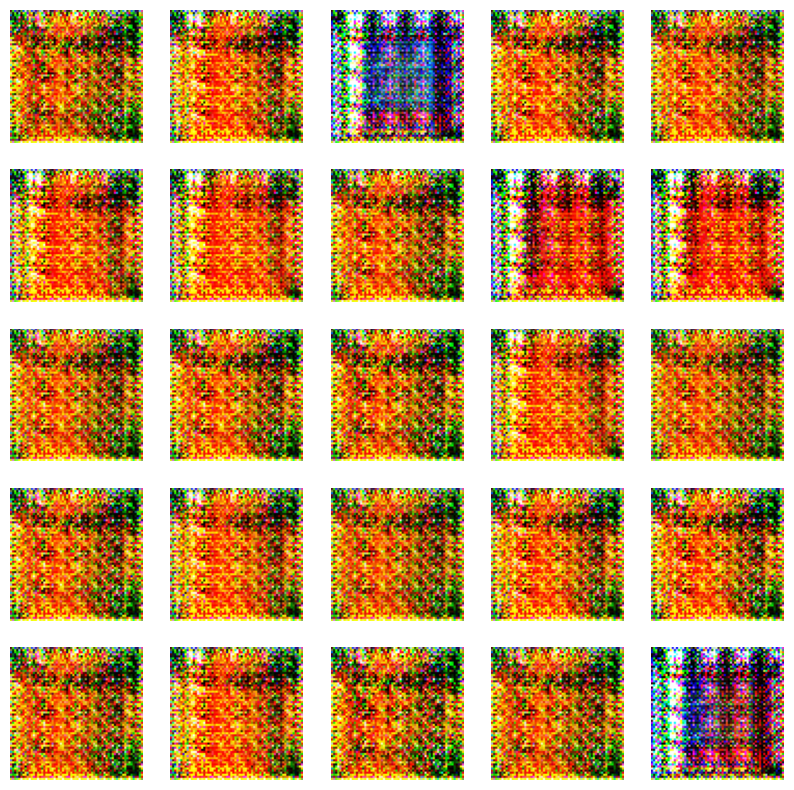

In [ ]:
import matplotlib.pyplot as plt

def generate_and_plot_images(generator, num_images):

    z = torch.randn(num_images, latent_dim)
    with torch.no_grad():
        generated_images = generator(z).detach().cpu().numpy()

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow((generated_images[i].transpose(1, 2, 0) + 1) / 2)
        plt.axis('off')
    plt.show()


generate_and_plot_images(generator, 25)

#В ходе проведенного эксперимента было установлено:
 Модель вариационного автокодировщика (VAE) демонстрирует значительно лучшие результаты обучения по сравнению с моделью StyleGAN. VAE не только проще в реализации, но и требует меньше времени на обучение. В частности, обучение VAE заняло всего 1.5 часа на графическом процессоре T4, в то время как обучение StyleGAN потребовало 5 часов.

Одной из основных проблем, с которыми мы столкнулись при обучении GAN, является сложность настройки параметров сети для достижения качественных результатов. Часто наблюдаемое явление генерации шума в процессе обучения GAN указывает на нестабильность модели. Несмотря на проведенные пять обучений, добиться стабильной работы StyleGAN не удалось, что подчеркивает сложности, связанные с этой архитектурой.

Таким образом, результаты нашего исследования подтверждают, что VAE является более эффективным и надежным выбором для задач генерации изображений, особенно в условиях ограниченного времени и ресурсов. В то время как StyleGAN обладает потенциалом для создания высококачественных изображений, его сложность и требования к обучению делают его менее предпочтительным для практического применения в текущих условиях.